In [16]:
import os

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import NLLLoss
from torch.optim import Adam
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable

warnings.simplefilter("ignore")

def show_img(img):
    plt.figure()
    plt.imshow(img.detach().cpu().numpy().reshape((28, 28)))
    plt.show()

class CausalConv1d(nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.left_padding = dilation * (kernel_size - 1)

    def forward(self, x):
        x = F.pad(x.unsqueeze(2), (self.left_padding, 0, 0, 0)).squeeze(2)

        return super(CausalConv1d, self).forward(x)

In [158]:
def receptive_field_size(total_layers, num_cycles, kernel_size,
                         dilation=lambda x: 2**x):
    """Compute receptive field size
    Args:
        total_layers (int): total layers
        num_cycles (int): cycles
        kernel_size (int): kernel size
        dilation (lambda): lambda to compute dilation factor. ``lambda x : 1``
          to disable dilated convolution.
    Returns:
        int: receptive field size in sample
    """
    assert total_layers % num_cycles == 0
    layers_per_cycle = total_layers // num_cycles
    dilations = [dilation(i % layers_per_cycle) for i in range(total_layers)]
    return (kernel_size - 1) * sum(dilations) + 1

class CausalModel(nn.Module):
    def __init__(self, input_size=28 * 28, output_size=28 * 28, kernel_size=3, bias=True):
        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size

        super(CausalModel, self).__init__()

        ch = 256

        self.stacks = 2
        self.layers = 2
        assert self.layers % self.stacks == 0
        layers_per_stack = self.layers // self.stacks

        self.start_conv = nn.Conv1d(in_channels=1, out_channels=ch, kernel_size=1)
        self.conv_layers = nn.ModuleList()

        for layer in range(self.layers):
            #dilation = 2**(layer % layers_per_stack)
            dilation = 1

            conv = CausalConv1d(in_channels=ch, out_channels=ch, kernel_size=kernel_size, bias=True, dilation=dilation)
            self.conv_layers.append(conv)

        self.last_conv_layers = nn.ModuleList([
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=ch, out_channels=ch, kernel_size=1),
            nn.Sigmoid(),
            nn.Conv1d(in_channels=ch, out_channels=2, kernel_size=1)
        ])

        self.receptive_field = receptive_field_size(self.layers, self.stacks, self.kernel_size)

    def forward(self, x):
        x = self.start_conv(x)
        for f in self.conv_layers:
            x = f(x)

        for f in self.last_conv_layers:
            x = f(x)

        return x

    def incremental_forward(self):
        self.eval()


In [162]:
SEED = 42
TRAIN_UPDATES = 30000
BATCH_SIZE = 32
LR = 3e-5
DEVICE = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
CPU_CORES = 4

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
    transforms.Lambda(lambda x: x.flatten(start_dim=1))
])
target_transform = transforms.Compose([
    transforms.Lambda(lambda x: x > 0.5),
    transforms.Lambda(lambda x: x.type(torch.LongTensor).squeeze())
])

train_dataset = torchvision.datasets.MNIST(root="./data/mnist", train=True, transform=default_transform,
                                           download=True)
val_dataset = torchvision.datasets.MNIST(root="./data/mnist", train=False, transform=default_transform,
                                         download=True)
train_dataloader = DataLoader(train_dataset, num_workers=CPU_CORES, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [163]:
model = CausalModel(kernel_size=2).cuda()
loss_fn = NLLLoss()
optimizer = Adam(params=model.parameters(), lr=LR)

for epoch in range(5):
    print(f"Epoch: {epoch + 1}")
    pbar = tqdm(train_dataloader)

    mean_loss = 0

    for x, _ in pbar:
        y = target_transform(x).cuda()
        yh = model.forward(x.cuda())
        log_probs = F.log_softmax(yh)

        loss = loss_fn(log_probs, y)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        pbar.set_description(desc=f"NLL={loss}")
        mean_loss += loss
    mean_loss = mean_loss/len(pbar)
    print(mean_loss)

Epoch: 1


NLL=3.240241527557373: 100%|██████████| 1875/1875 [02:24<00:00, 12.95it/s] 


tensor(3.2415, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2


NLL=3.2369372844696045:  12%|█▏        | 224/1875 [00:18<02:13, 12.41it/s]


KeyboardInterrupt: 

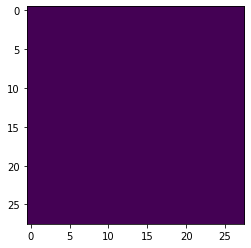

In [149]:
testmodel = CausalModel(kernel_size=28).cuda()

test = model.generate(784)

show_img(test)

torch.Size([32, 784])


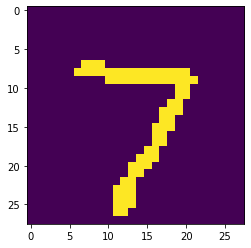

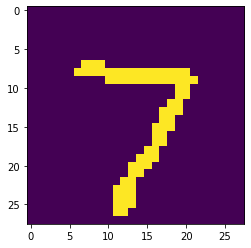

In [150]:
for x, _ in val_dataloader:
    yh = torch.argmax(model.forward(x.cuda()), 1)
    print(y.size())

    y = target_transform(x)

    show_img(y[0, :])
    show_img(yh[0, :])
    break

In [151]:
model.state_dict()

OrderedDict([('start_conv.weight',
              tensor([[[ 0.3490]],
              
                      [[ 0.4930]],
              
                      [[-0.5022]],
              
                      [[-1.0617]],
              
                      [[-0.9840]],
              
                      [[ 0.4648]],
              
                      [[ 1.0151]],
              
                      [[-0.6543]],
              
                      [[-0.4407]],
              
                      [[ 0.8001]],
              
                      [[-0.7241]],
              
                      [[ 0.9464]],
              
                      [[-0.8833]],
              
                      [[-0.3246]],
              
                      [[-0.3488]],
              
                      [[-0.9254]],
              
                      [[ 0.9991]],
              
                      [[ 0.8848]],
              
                      [[ 0.6807]],
              
               